In [214]:
# coding: utf-8

import requests
import zipfile
import os
import fnmatch

def grep(target_file, input_word):
    grep_list = [line[:-1] for line in [line for line in open(target_file) if line.find(input_word)>=0]]
    return grep_list

def download_file(url):
    dirpath = './data_files/'
    fname =  dirpath + url.split('/')[-1]
    r = requests.get(url, stream=True)
    with open (fname, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
                f.flush()
        return fname
    return False

def zip_extract(fname):
    dirpath = './data_files/'
    zfile = zipfile.ZipFile(fname)
    zfile.extractall(dirpath)

if __name__ == '__main__':
    #　保存ファイルの場所
    dirpath = './data_files/'
    
    # 福沢諭吉テキストurlのリストを作る！
    target_file = 'aozora_word_list_utf8.csv'
    input_word = input('find word --> ')
    text_url_list = [line.split(',')[45] for line in grep(target_file, input_word)]
    
    #サーバーからデータをダウンロード && ファイルの展開
    for url in text_url_list:
        fname = download_file(url)
        # fname = './data_files/43029_ruby_23223.zip' #deback
        if fname:
            print('{} is download'.format(fname))
            zip_extract(fname)
        !sleep 1.0

    #すべて展開する
    # txt_list =[./data_files/kyoto_gakkono_ki.txt]
    txt_list = fnmatch.filter(os.listdir(dirpath), '*.txt')
    print(len(fname) == len(txt_list))
    
    #txt_list全体にdirpathを加える
    mapped_txt_list = map(lambda txt_path:dirpath+txt_path, txt_list)

find word --> 福沢,諭吉
./data_files/43029_ruby_23223.zip is download
./data_files/43064_ruby_24472.zip is download
./data_files/45257_ruby_18658.zip is download
./data_files/45664_ruby_24519.zip is download
./data_files/46684_ruby_26314.zip is download
./data_files/46685_ruby_24921.zip is download
./data_files/46686_ruby_24922.zip is download
./data_files/46734_ruby_25781.zip is download
./data_files/46826_ruby_24770.zip is download
./data_files/46827_ruby_24772.zip is download
./data_files/46848_ruby_42407.zip is download
./data_files/46890_ruby_25782.zip is download
./data_files/47030_ruby_26828.zip is download
./data_files/47054_ruby_29646.zip is download
./data_files/47061_ruby_28378.zip is download
./data_files/47063_ruby_32086.zip is download
./data_files/47149_ruby_27921.zip is download
./data_files/47150_ruby_27922.zip is download
./data_files/47151_ruby_27923.zip is download
./data_files/47152_ruby_27924.zip is download
./data_files/47219_ruby_33285.zip is download
./data_files/4

In [47]:
# 正規表現処理を関数化
# mapped_txt_listはgenerateで構成されているため一度使うと消える

import codecs
import re

def normalize_text(text):
    # ヘッダ部分の除去
    text = re.split('-{5,}', text)[2]
    # フッタ部分の除去
    text = re.split('底本：', text)[0]
    # |の除去
    text = text.replace('｜', '')
    text = text.replace('|', '')
    # ルビの除去
    text = re.sub('《.+?》', '', text)
    # 入力注の除去
    text = re.sub('［＃.+?］', '', text)
    # 空行の除去
    text = re.sub('\n\n', '\n', text)
    text = re.sub('\u3000', '', text)
    # CR,LFの除去
    text = re.sub('\r', '', text)
    text = re.sub('\n', '', text)
    return text

if __name__ == '__main__':
    all_sjis_text = "" # 処理済みテキストの格納

    # ファイル読込み、内部表現化
    for text in mapped_txt_list:
        f = codecs.open(text, "r", "sjis")
        sjis_text = f.read()
        f.close()    
        sjis_text = normalize_text(sjis_text)
        all_sjis_text += sjis_text #テキストに保存
        
    # 整形結果確認   
    print(all_sjis_text[:100])
    print('\n\n')
    print(all_sjis_text[-100:])

明治五年申五月朔日、社友早矢仕氏とともに京都にいたり、名所旧跡はもとよりこれを訪うに暇あらず、博覧会の見物ももと余輩上京の趣意にあらず、まず府下の学校を一覧せんとて、知る人に案内を乞い、諸処の学校に行



難きほどのものなれば、貧富ともに勉むべきは学問にして、ただその教場をして仙境ならしめざること、吾々のつねに注意して怠らざるところなれば、学生諸氏もおのおの自から心してこの注意を空しゅうせしむるなかれ。


In [336]:
from janome.tokenizer import Tokenizer

# Tokenneizerインスタンスの生成 
t = Tokenizer()

# テキストを引数として、形態素解析の結果、名詞のみの配列で抽出する関数を定義 
def extract_words(text):
    tokens = t.tokenize(text)
    return [token.base_form for token in tokens if  token.part_of_speech.split(',')[0] in ['名詞','動詞','形容詞'] if token.part_of_speech.split(',')[1] in ['一般', 'サ変接続', '固有名詞', '形容動詞語幹', '副詞可能', '自立']]

if __name__ == '__main__':
    # 全体のテキストを句点で区切った配列にする。
    sentence_list = all_sjis_text.split('。')

    # それぞれの文章を単語リストに変換
    word_list = [extract_words(sentence)for sentence in sentence_list]
    
    # 単語リストの結果を一部表示
    for word in word_list:
        print(word) 

15.308985615542687


In [353]:
# word2vecの使い方を調べる
# 適切なハイパーパラメータを決める
#単語数 / 文章数　=　平均単語数(15)でwindowを指定

import gensim

model = gensim.models.Word2Vec(
word_list, 
sg = 1, #skip-gram :on
size = 100, # 次元
window = 15, #similar_words 
hs = 0,
)
print(model)

model.train(word_list, total_examples=len(word_list), epochs=5)

Word2Vec(vocab=2897, size=100, alpha=0.025)


(291419, 409745)

In [352]:
#福沢諭吉に関連するワードを任意で入力して見つけよう！

# 結果の確認
w1='諭吉'
w2= input('free word -->')
try:
    #２つの単語の類似性を数値で出す。
    print(model.wv.similarity(w1, w2))
    
    print('\n') # 改行
    
    #他の類似性の高い単語の表示
    print('類似性が高いワード')
    pos_w = model.wv.most_similar(positive=w2, topn=5)
    for item in pos_w:
        print(item[0], item[1])
    
    print('\n')
    
    print('類似性が低いワード')
    neg_w = model.wv.most_similar(negative=w2, topn=5)
    for item in neg_w:
        print(item[0], item[1])
        
except:
    print('{}は類似性がありません'.format(w2))

free word -->金
0.2213705


類似性が高いワード
払う 0.8590715527534485
費やす 0.8499720096588135
貸す 0.8486815094947815
普請 0.8483724594116211
役人 0.8465108275413513


類似性が低いワード
我輩 0.10916878283023834
政治 0.09916643798351288
主義 0.08856023848056793
公徳 0.08446414768695831
私権 0.05762230604887009


/Users/hamaguchikazuki/.pyenv/versions/3.6.5/envs/ppgVC/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


/Users/hamaguchikazuki/.pyenv/versions/3.6.5/envs/ppgVC/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  del sys.path[0]
/Users/hamaguchikazuki/.pyenv/versions/3.6.5/envs/ppgVC/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/Users/hamaguchikazuki/.pyenv/versions/3.6.5/envs/ppgVC/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/Users/hamaguchikazuki/.pyenv/versions/3.6.5/envs/ppgVC/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling ba

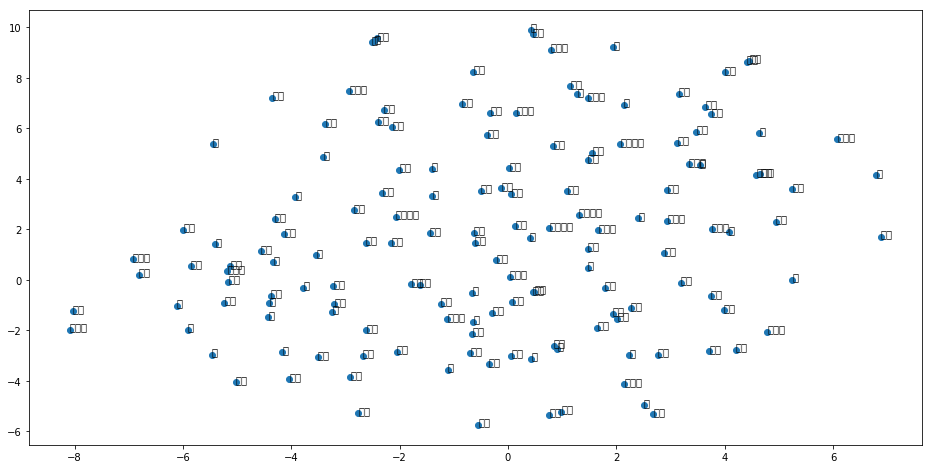

In [360]:
# modelの可視化

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib

matplotlib.get_configdir()
%matplotlib inline
font = {'family': 'IPAexGothic'}
matplotlib.rc('font', **font)
matplotlib.rcParams['font.family']

sim_words = [x[0] for x in model.most_similar(w2, topn=150)]
sim_words.append(w2)

labels = [word for word in sim_words]
vecs = [model[word] for word in sim_words]

tsne = TSNE(random_state=0)
result = tsne.fit_transform(vecs)

# 座標点の作成
x = [vec[0] for vec in result]
y = [vec[1] for vec in result]

plt.figure(figsize=(16, 8))
plt.scatter(x, y)

for i in range(len(x)):
#     plt.scatter(x[i], y[i])
    plt.annotate(
                labels[i],
                xy=(x[i], y[i]),
                xytext=(0, 0),
                textcoords='offset points'
                )
plt.show()